# Basic example

This example demonstrates some of the core functionality and export features provided by rabpro.

Note: you will need to download HydroBasins to run this demo. See [this notebook](https://github.com/VeinsOfTheEarth/rabpro/blob/main/docs/source/examples/notebooks/downloading_data.ipynb) for download instructions.

In [11]:
import pandas as pd
import geopandas as gpd
import rabpro
from matplotlib import pyplot as plt

First, we need to specify a point for which we'd like a watershed delineated.

In [5]:
coords = (56.22659, -130.87974)

Now we can initialize the profiler. The rabpro profiler is the main entry point into the package - it provides wrapper funcitons for most of the rabpro's core functionality.

Note that we can optionally specify a drainage area (`da`) or set `force_merit` to `True`, to ensure that we use MERIT data rather than HydroBasins to perform basin delineation.

In [16]:
rpo = rabpro.profiler(coords, name='basic_test', rebuild_vrts=False)

C:\Users\318596\Anaconda3\envs\erosion\lib\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


rabpro can now compute the watershed for this point. Since we are not providing a pre-known drainage area to the profiler or specifying `force_merit=True`, rabpro will use HydroBasins to delineate the watershed. Delineation may take a minute or two as rabpro has to identify the correct level-12 HydroBasins shapefile and load it into memory (these files are >100MB).

In [17]:
%%capture
rpo.delineate_basin()

The basin geometry is stored in a GeoPandas GeoDataFrame, and can be accessed through the `rpo` object.

C:\Users\318596\Anaconda3\envs\erosion\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<AxesSubplot:>

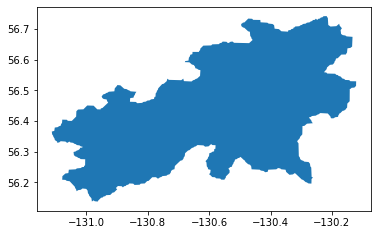

In [9]:
rpo.watershed.plot()

Next, we try to compute the river elevation profile. This will fail because we have not yet downloaded MERIT data.

In [10]:
rpo.elev_profile(dist_to_walk_km=5)

Extracting flowpath from DEM...
Cannot map provided point to a flowline; unable to extract centerline. Reason #5


If you'd like to complete this task, you will need to download the MERIT tile `n30w150`. Detailed instructions, including how to get a username and password for MERIT-Hydro downloads, are [here](https://github.com/VeinsOfTheEarth/rabpro/blob/main/docs/source/examples/notebooks/downloading_data.ipynb). Note that the MERIT tile will consume ~1.6 GB of space when unzipped.

`download_merit_hydro()` will automatically rebuild virtual rasters, which are how rabpro interacts with the individual geotiffs, after downloading a tile.

In [2]:
from rabpro import data_utils
data_utils.download_merit_hydro('n30w150', username=hidden, password=hidden, proxy='user@proxy:port')

100%|█████████████████████████████████████████████████████████████████████████████| 72.0M/72.0M [00:09<00:00, 7.31MB/s]


100%|███████████████████████████████████████████████████████████████████████████████| 866M/866M [01:34<00:00, 9.16MB/s]


100%|███████████████████████████████████████████████████████████████████████████████| 502M/502M [01:11<00:00, 7.02MB/s]


100%|█████████████████████████████████████████████████████████████████████████████| 25.3M/25.3M [00:10<00:00, 2.33MB/s]


Building flow direction virtual raster DEM from MERIT tiles...
0...10...20...30...40...50...60...70...80...90...100 - done.

Building drainage areas virtual raster DEM from MERIT tiles...
0...10...20...30...40...50...60...70...80...90...100 - done.

Building hydrologically-processed elevations virtual raster DEM from MERIT tiles...
0...10...20...30...40...50...60...70...80...90...100 - done.

Building width virtual raster from MERIT tiles...
0...10...20...30...40...50...60...70...80...90...100 - done.



Now we can try again:

Extracting flowpath from DEM...


C:\Users\318596\Anaconda3\envs\erosion\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\318596\Anaconda3\envs\erosion\lib\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


Text(0, 0.5, 'Elevation')

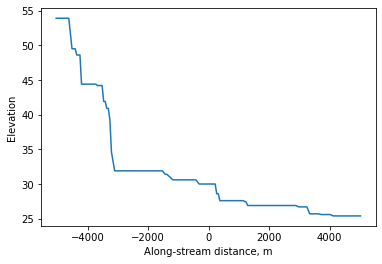

In [18]:
rpo.elev_profile(dist_to_walk_km=5)
plt.plot(rpo.flowline['Distance (m)'], rpo.flowline['Elevation (m)'])
plt.xlabel('Along-stream distance, m')
plt.ylabel('Elevation')

The along-stream distance is with respect to the provided coordinate. You can use the `rpo.flowline` GeoDataFrame to compute slopes.

You can export the `watershed` GeoDataFrame and/or the `flowline` GeoDataFrame using the `.export()` method.

In [19]:
%%capture
rpo.export("all")

Once the subbasins are delinated, rabpro can use Google Earth Engine (GEE) to compute statistics for each subbasin. Using Google Earth Engine reduces the need to store large datasets locally, and speeds up computation by using GEE's parallel distributed computing capabilities.

Note: In order to use rabpro for basin statistics, you'll need to sign up for a GEE account. See rabpro's documentation for more information.

In [20]:
# Specify which statistics to calculate for the JRC/GSW1_3/GlobalSurfaceWater dataset's occurrence band
statlist = ['min', 'max', 'range', 'std', 'sum', 'pct50', 'pct3']
data = rabpro.basin_stats.Dataset("JRC/GSW1_3/GlobalSurfaceWater", "occurrence", stats=statlist)

d, t = rpo.basin_stats([data], folder="rabpro test")

Submitting basin stats task to GEE for JRC/GSW1_3/GlobalSurfaceWater...


The output data will be placed in the `rabpro test` folder in your Google Drive if it already exists. If not, GEE will create a new `rabpro test` folder at the root level of your Drive.

`basin_stats` returns a url to the resulting csv data which can be read directly with `pandas`:

In [21]:
pd.read_csv(d[0])

,system:index,count,da_km2,max,mean,min,p3,p50,range,sum,.geo
0,0_0,91173,2131.577825,100,80.523354,0,22.328632,91.636754,100,4.757363e+06,NaN
